In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Tuple

In [26]:
def keep_highest_occurences(df: pd.DataFrame, col: str, n: int) -> Tuple[pd.DataFrame, float]:
    # keep n highest occurrences of column col
    selection = df[col].value_counts()[0:n].index

    # calculate the instances of items selected
    nb_instances_selected = df[col].value_counts()[0:n].values.sum()
    total = df[col].value_counts().values.sum()

    # calculate the percentage of selected items
    percentage_of_selected_instances = nb_instances_selected/total
    
    return df[df[col].isin(selection)], percentage_of_selected_instances

In [46]:
def display_impact_per_category(df, col, split, n, add_count=False):
    if split is not None:
        # split nested category into one row per instance of this category  [A, B] becomes one row with A and one with B.
        unnested_category = pd.DataFrame(df[col].str.split(split, expand=True).stack(), columns = [col])
        unnested_category = unnested_category[unnested_category != 'nan']

        # filter the instances to only keep the n most frequent
        unnested_category_filtered, percentage_of_selected_instances = keep_highest_occurences(unnested_category, col=col, n=n) 
        category_df = unnested_category_filtered.reset_index(level=1, drop=True)    

        # add the data of climate_change and resource_use_fossils for these new unnested rows
        df_merged = pd.merge(category_df, df[['climate_change', 'resource_use_fossils']], left_index=True, right_index=True, how='left')
        # we make sure we only have the relevant instances
        df_results = df_merged[df_merged[col].isin(unnested_category_filtered[col].unique())]
    else:
        # here no need to unnest a column, we directly select the n most frequent instances
        df_results, percentage_of_selected_instances = keep_highest_occurences(df, col=col, n=12) 
    if add_count:
        # add the count next to the name of the instance: for example if there is 21 instance of category "A"
        # The title of category "A" becomes: "A [21]"
        category_count = df_results[col].value_counts()
        category_count.columns = ['count']
        df_results = pd.merge(df_results, category_count, left_on=col, right_index=True, how='left')
        df_results[col] = df_results[col] + ' [' + df_results['count'].astype(str) + ']'

    # order by climate_change descending
    order = df_results.groupby([col]).agg({'climate_change':'mean'}).sort_values(['climate_change'], ascending=False).index

    # plot the climate_change and resource_use_fossils per instance
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    sns.barplot(df_results, x='climate_change', y=col, order=order, color='tab:blue', errorbar='ci', ax=ax[0])
    ax[0].set_title(f'Climate change per {col}')
    
    sns.barplot(df_results, x='resource_use_fossils', y=col, order=order, color='tab:blue', errorbar='ci', ax=ax[1])
    ax[1].set_title(f'resource_use_fossils per {col}')
    
    fig.suptitle(f"Impact per {col} [{round(percentage_of_selected_instances*100,0)}% of the products represented]")
    
    plt.show()

## Load data

In [28]:
df_raw = pd.read_csv('../data/fairlymade_products_impacts.csv')

## Dataset analysis

In [29]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8919 entries, 0 to 8918
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   study_id               8919 non-null   object 
 1   product_type           8919 non-null   object 
 2   nb_components          8919 non-null   int64  
 3   composition            8914 non-null   object 
 4   raw_material_country   877 non-null    object 
 5   weaving_country        4167 non-null   object 
 6   dyeing_country         7342 non-null   object 
 7   manufacturing_country  8919 non-null   object 
 8   plane_in_transports    8919 non-null   bool   
 9   climate_change         8919 non-null   float64
 10  resource_use_fossils   8918 non-null   float64
dtypes: bool(1), float64(2), int64(1), object(7)
memory usage: 705.6+ KB


In [30]:
df_raw.sample(5)

,study_id,product_type,nb_components,composition,raw_material_country,weaving_country,dyeing_country,manufacturing_country,plane_in_transports,climate_change,resource_use_fossils
2479,36d87bee-1c0b-4038-88c4-be285905e20a,SHORTS,3,"MOTHER OF PEARL, POLYESTER, NATURAL RUBBER, EL...",NaN,"JP, FR",JP,IT,False,5.079623,85.267431
7523,ec0c64df-e0ef-422e-ad29-781683b9049b,SWEATSHIRTS,1,"ORGANIC COTTON, MODAL",NaN,NaN,IN,IN,False,2.651436,42.305053
7803,b476eed4-4333-401c-b1b3-1fec86a93c47,SWEATSHIRTS,1,COTTON,NaN,NaN,PT,PT,False,13.835975,199.522825
3551,d2c935e5-3e8d-4ee6-9ee8-e7d45665f995,DRESSES,1,SILK,NaN,CN,CN,CN,True,4.079137,44.596559
4251,a37b7d29-e975-4f5b-946b-e0f6ee1e3b8f,TSHIRTS,1,ORGANIC COTTON,NaN,NaN,NaN,PT,False,0.742540,23.384473


In [31]:
df_raw.describe()

,nb_components,climate_change,resource_use_fossils
count,8919.000000,8919.000000,8918.000000
mean,1.563628,22.444302,178.237971
std,0.715199,34.525508,129.616346
min,1.000000,0.341666,0.000000
25%,1.000000,5.738983,81.639080
50%,1.000000,11.708067,146.395439
75%,2.000000,23.898276,235.716986
max,3.000000,558.906266,987.385617


In [32]:
df_raw['product_type'].value_counts()[-10:]

product_type
HOMEWEARS              76
JUMPSUITS & BOILERS    68
BRAS                   58
ZIPPED COATS           41
ONE PIECES             40
BODYSUITS              31
LEGGINGS               15
SHIRT-DRESSES          10
BIBS & BRACES           6
STOCKINGS & TIGHTS      3
Name: count, dtype: int64

#### Is there duplicated data?

In [33]:
df_raw[df_raw.duplicated()]

,study_id,product_type,nb_components,composition,raw_material_country,weaving_country,dyeing_country,manufacturing_country,plane_in_transports,climate_change,resource_use_fossils


In [34]:
df_raw[df_raw.duplicated(subset=['study_id'])]

,study_id,product_type,nb_components,composition,raw_material_country,weaving_country,dyeing_country,manufacturing_country,plane_in_transports,climate_change,resource_use_fossils


## Column analysis

Here we are trying to get a better understanding of the columns in this dataset.

First observations:
- climate_change and resource_use_fossils seem to be the columns to predict
- Clothes have few components (maximum 3)
- raw_material_country, weaving_country and dyeing_country are the columns with the most missing values
- composition and countries columns can have multiple values per row (we need to unnest these columns)
- study_id is probably not very interesting to use for this study case

In [35]:
print(len(df_raw['composition'].str.split(', ', expand=True).stack().unique()))

df_raw['composition'].str.split(', ', expand=True).stack().value_counts()[0:15]

117


COTTON                3727
POLYESTER             2281
ELASTANE              1921
POLYAMIDE             1364
VISCOSE               1318
ORGANIC COTTON        1126
CASHMERE               924
SILK                   703
FLAX                   653
SHEEP WOOL             531
RECYCLED POLYESTER     525
MERINO WOOL            376
VIRGIN WOOL            291
NYLON                  221
ZAMAK                  218
Name: count, dtype: int64

In [36]:
rows = []
for col in ['raw_material_country', 'weaving_country', 'dyeing_country', 'manufacturing_country']: 
    rows.append([col, round(df_raw[col].isna().sum()/len(df_raw[col].isna()), 2)])

df_missing_countries = pd.DataFrame(rows, columns = ['category', 'missing_data_in_percentage'])
df_missing_countries

,category,missing_data_in_percentage
0,raw_material_country,0.90
1,weaving_country,0.53
2,dyeing_country,0.18
3,manufacturing_country,0.00


In [37]:
rows = []
for col in ['raw_material_country', 'weaving_country', 'dyeing_country', 'manufacturing_country']: 
    df = df_raw.copy()
    df.loc[:,col] = df[col].str.replace(',', '')
    df = pd.DataFrame(df[col].str.split(' ', expand=True).stack(), columns = [col])
    rows.append([col, len(df[col].unique())])

df_unique_countries = pd.DataFrame(rows, columns = ['category', 'number of unique countries'])
df_unique_countries

,category,number of unique countries
0,raw_material_country,35
1,weaving_country,35
2,dyeing_country,38
3,manufacturing_country,44


## Data analysis

### Distribution of labels

/home/maxou1909/miniconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/maxou1909/miniconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


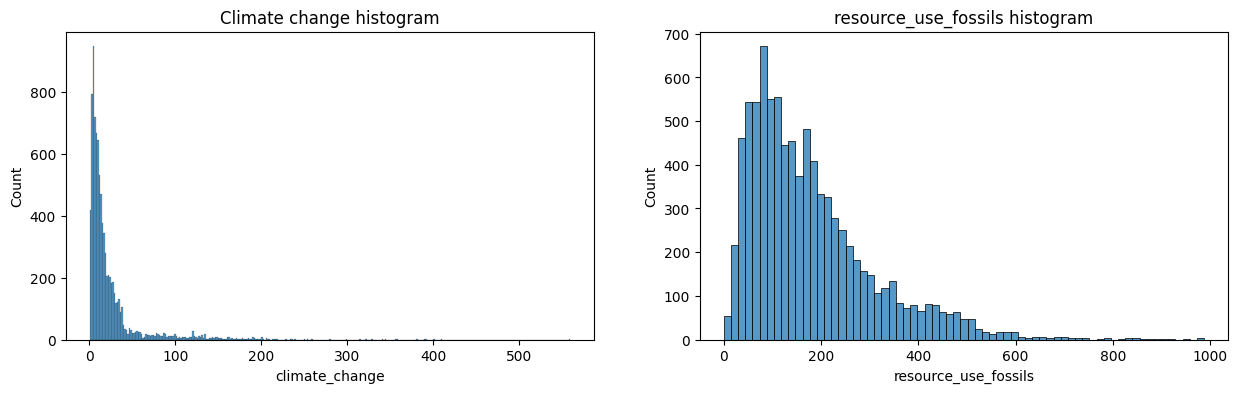

In [38]:
df = df_raw.copy()

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(df, x='climate_change', ax=ax[0])
ax[0].set_title('Climate change histogram')

sns.histplot(df, x='resource_use_fossils', ax=ax[1])
ax[1].set_title('resource_use_fossils histogram')

plt.show()

### Impact per plane_in_transport

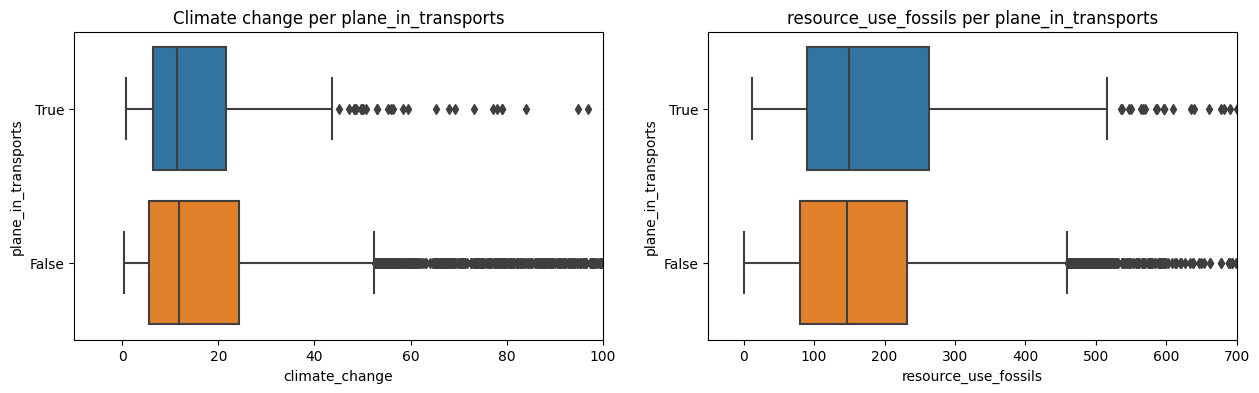

In [39]:
df_ = df_raw.copy()
df_['plane_in_transports'] = df_['plane_in_transports'].astype(str)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
sns.boxplot(df_, x='climate_change', y='plane_in_transports', order=['True', 'False'], ax=ax[0])
ax[0].set_title('Climate change per plane_in_transports')
ax[0].set_xlim([-10, 100])

sns.boxplot(df_, x='resource_use_fossils', y='plane_in_transports', order=['True', 'False'], ax=ax[1])
ax[1].set_title('resource_use_fossils per plane_in_transports')
ax[1].set_xlim([-50, 700])

plt.show()

### Impact per nb_components

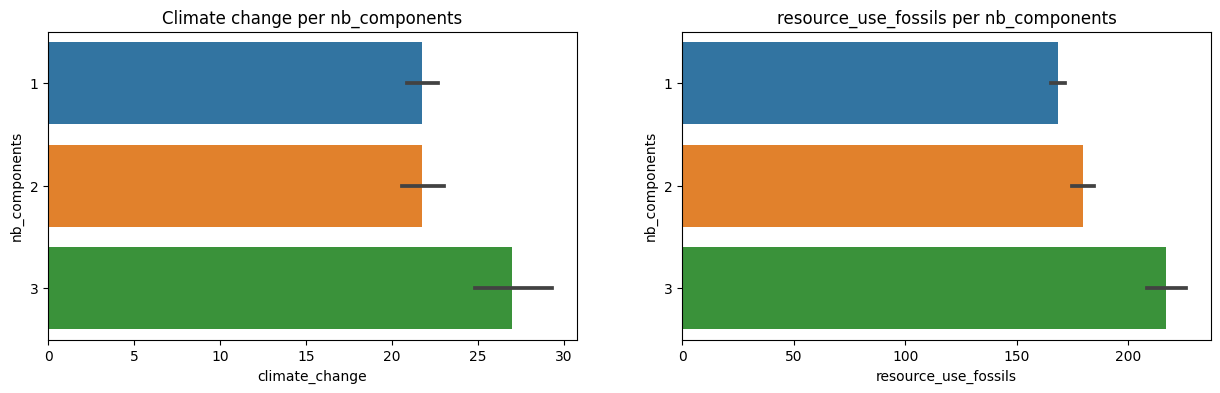

In [40]:
df_ = df_raw.copy()
df_['nb_components'] = df_['nb_components'].astype(str)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
sns.barplot(df_, x='climate_change', y='nb_components', order=['1', '2', '3'], errorbar='ci', ax=ax[0])
ax[0].set_title('Climate change per nb_components')

sns.barplot(df_, x='resource_use_fossils', y='nb_components', order=['1', '2', '3'], errorbar='ci', ax=ax[1])
ax[1].set_title('resource_use_fossils per nb_components')

plt.show()

### Impact per product_type

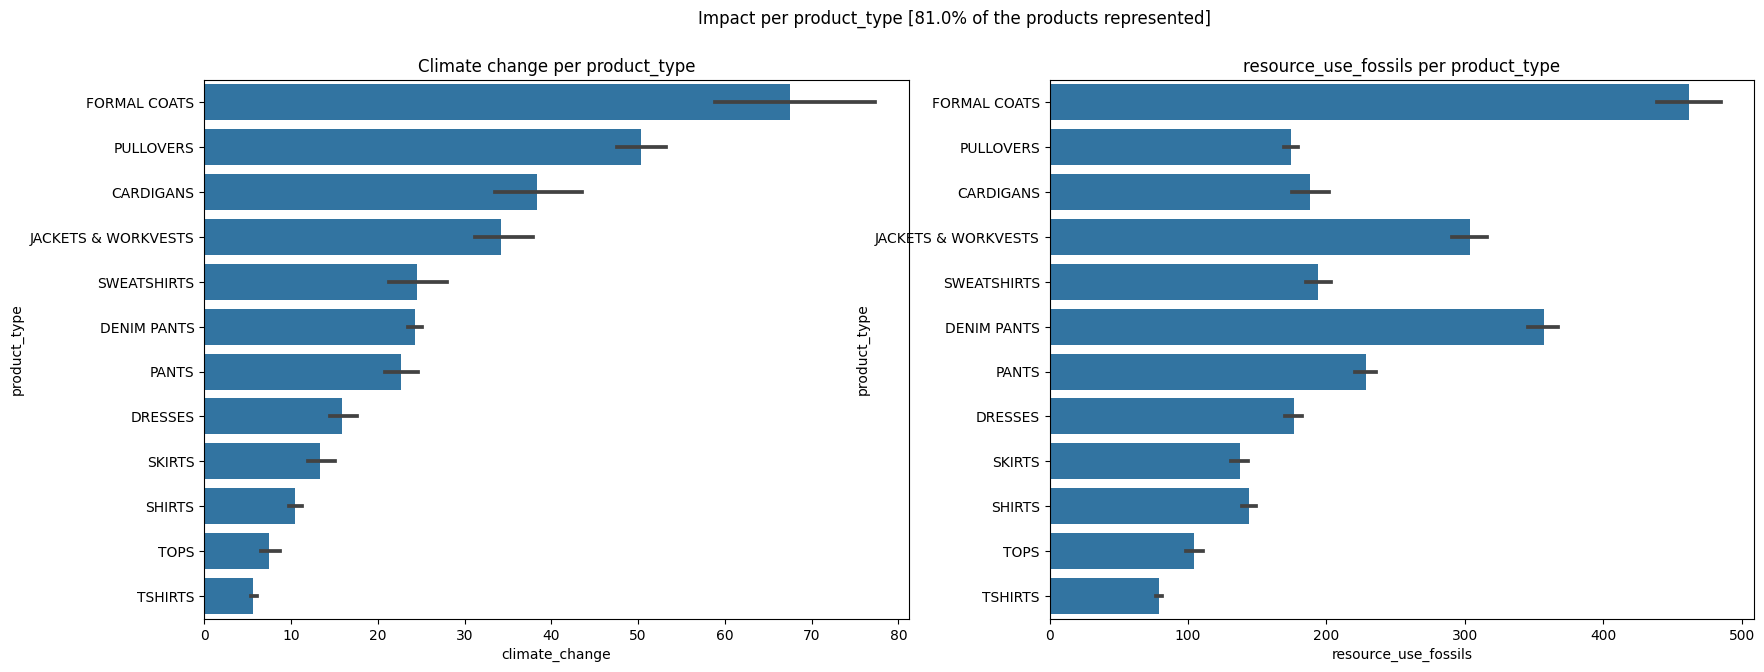

In [47]:
display_impact_per_category(df_raw, col='product_type', split=None, n=12, add_count=False)

### Impact per material

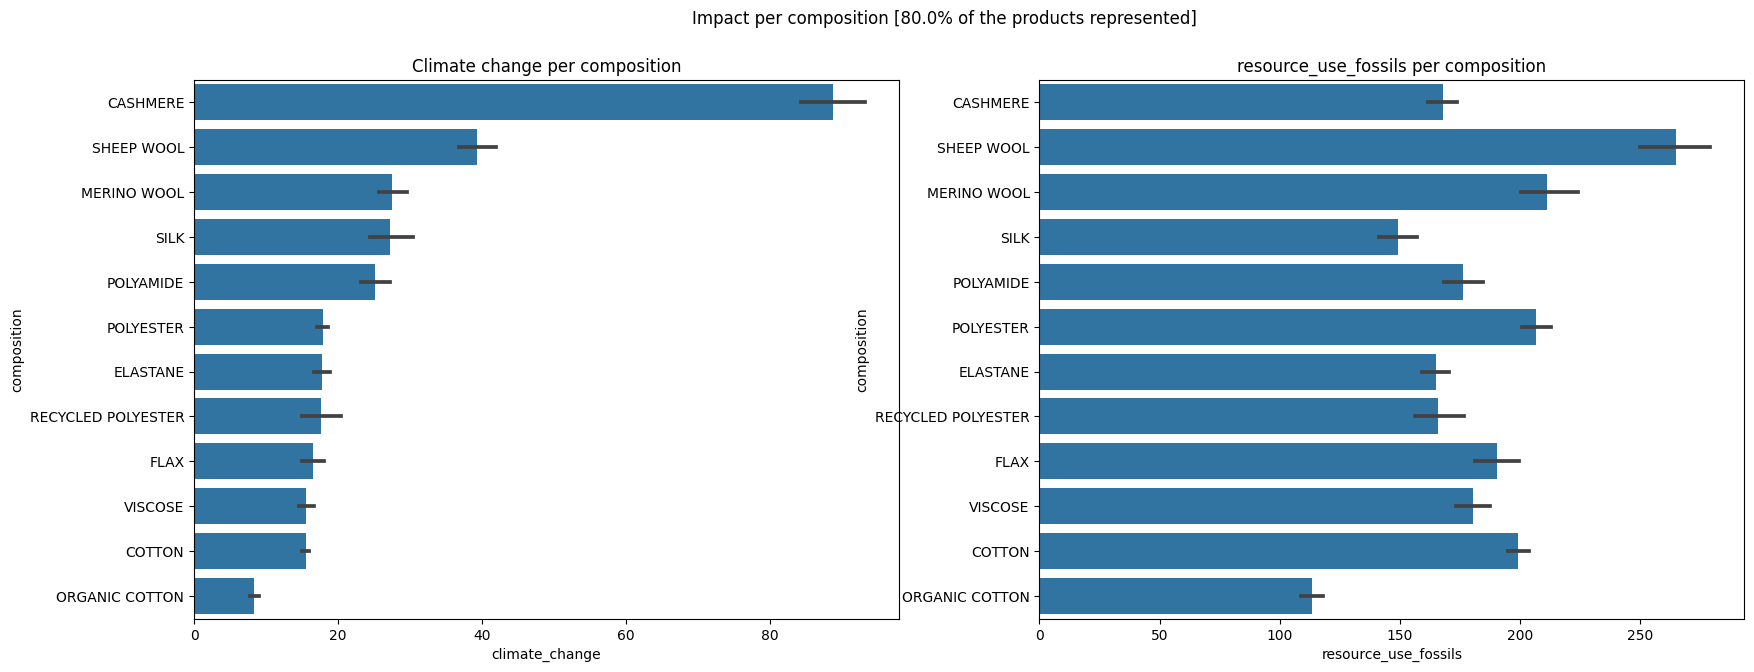

In [48]:
display_impact_per_category(df_raw, col='composition', split=', ', n=12, add_count=False)

### Impact per country - TSHIRTS

/tmp/ipykernel_48634/786640267.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'countries'] = df['manufacturing_country'].astype(str) + ' ' \


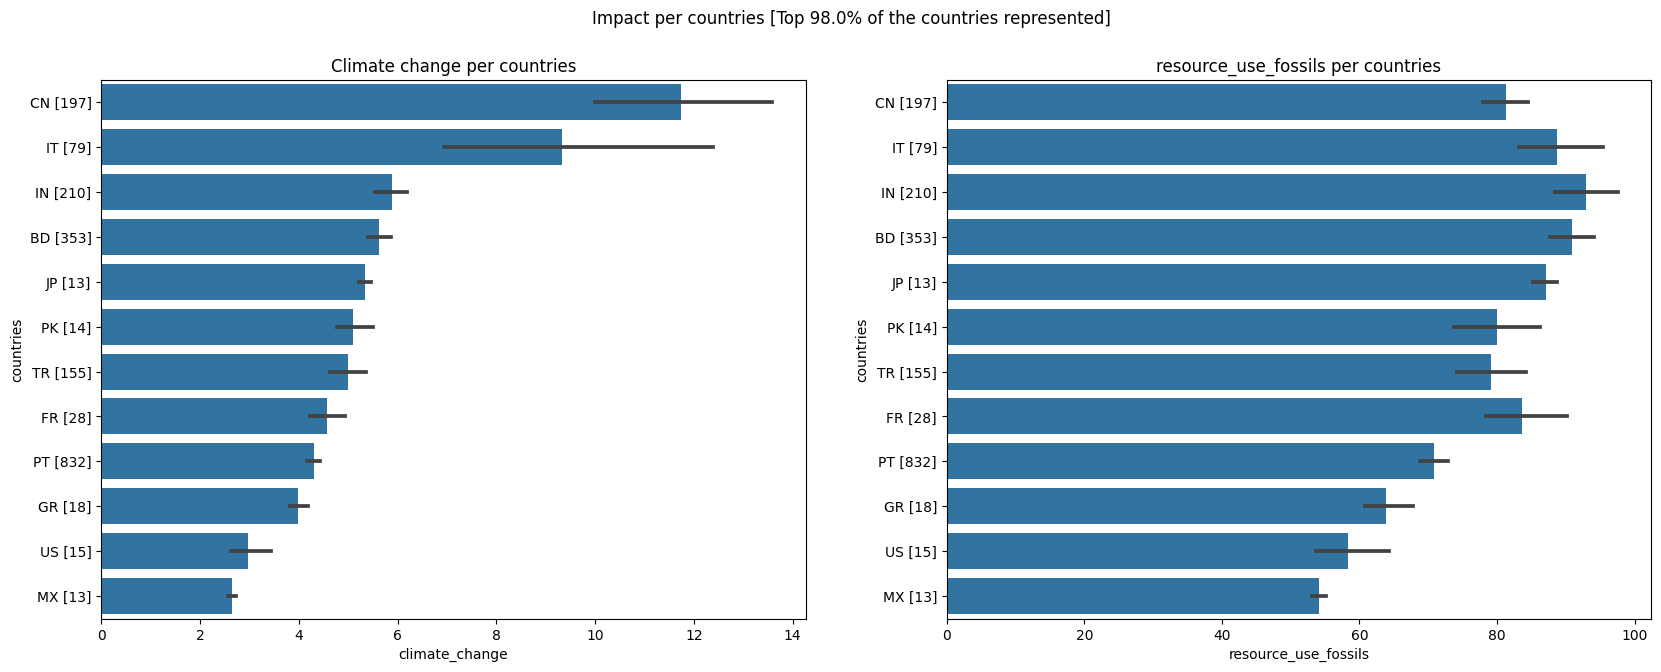

In [19]:
df = df_raw[df_raw['product_type'] == 'TSHIRTS']

df.loc[:,'countries'] = df['manufacturing_country'].astype(str) + ' ' \
                    + df['dyeing_country'].astype(str) + ' ' \
                    + df['weaving_country'].astype(str) + ' ' \
                    + df['raw_material_country'].astype(str)

df.loc[:,'countries'] = df['countries'].str.replace(',', '')

display_impact_per_category(df, col='countries', split=' ', n=12, add_count=True)

### Impact per country and per technique

/tmp/ipykernel_48634/3896664122.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['countries'] = df[col].astype(str)


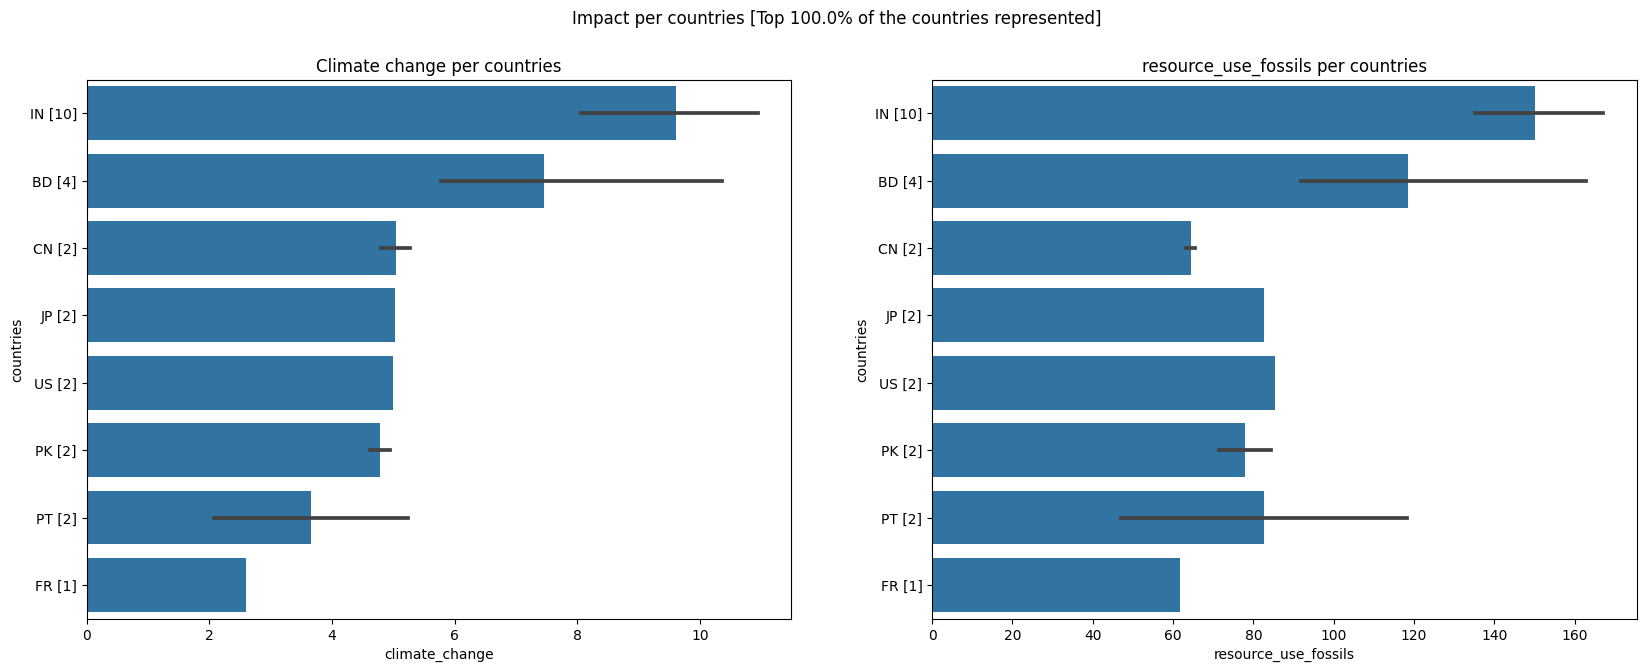

/tmp/ipykernel_48634/3896664122.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['countries'] = df[col].astype(str)


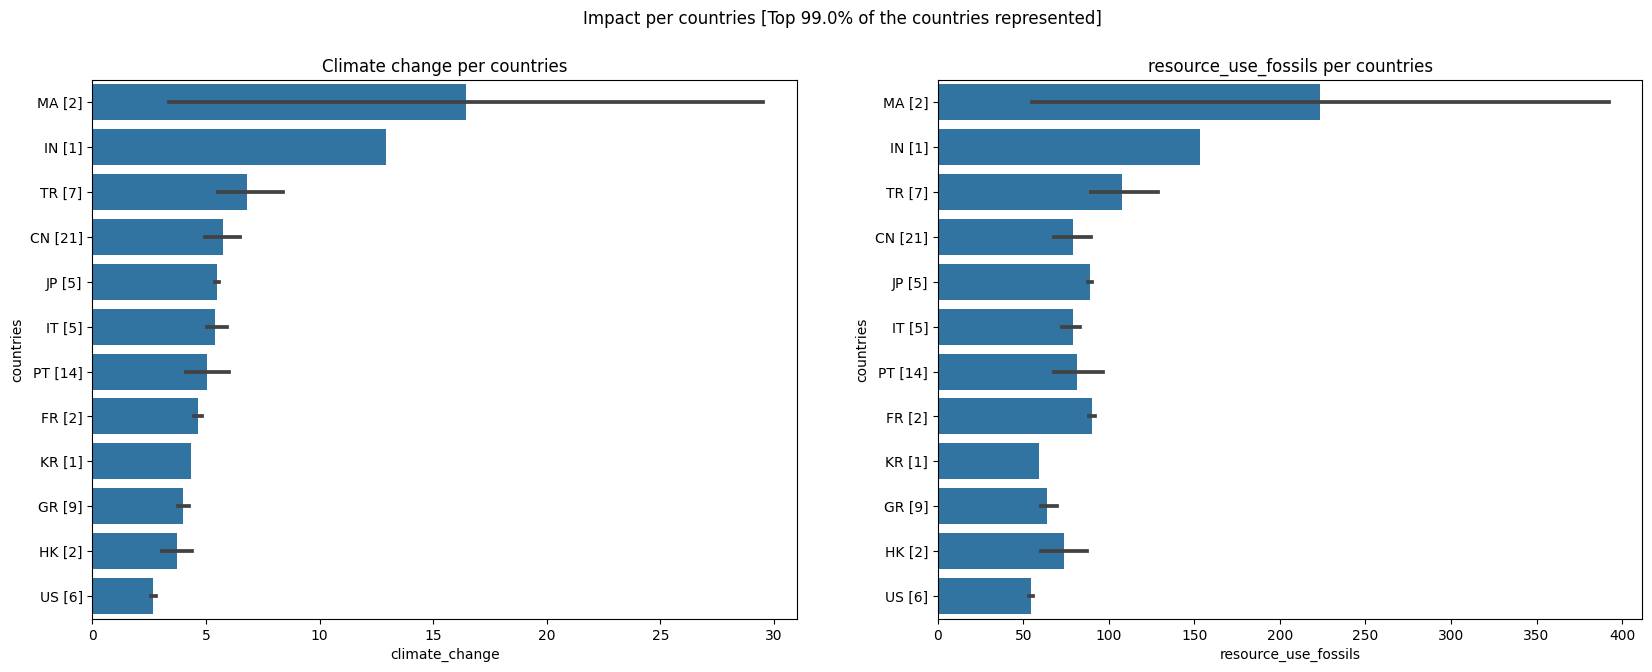

/tmp/ipykernel_48634/3896664122.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['countries'] = df[col].astype(str)


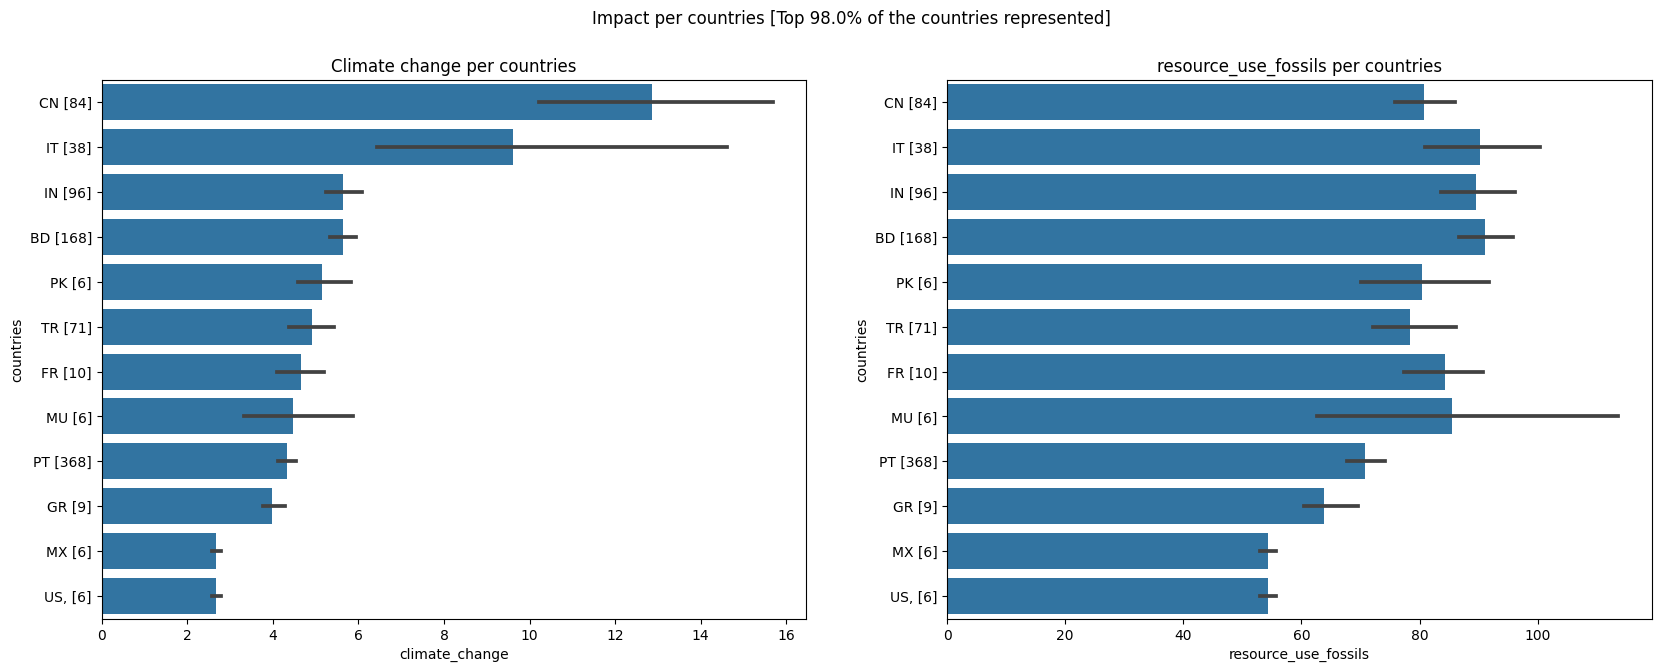

/tmp/ipykernel_48634/3896664122.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['countries'] = df[col].astype(str)


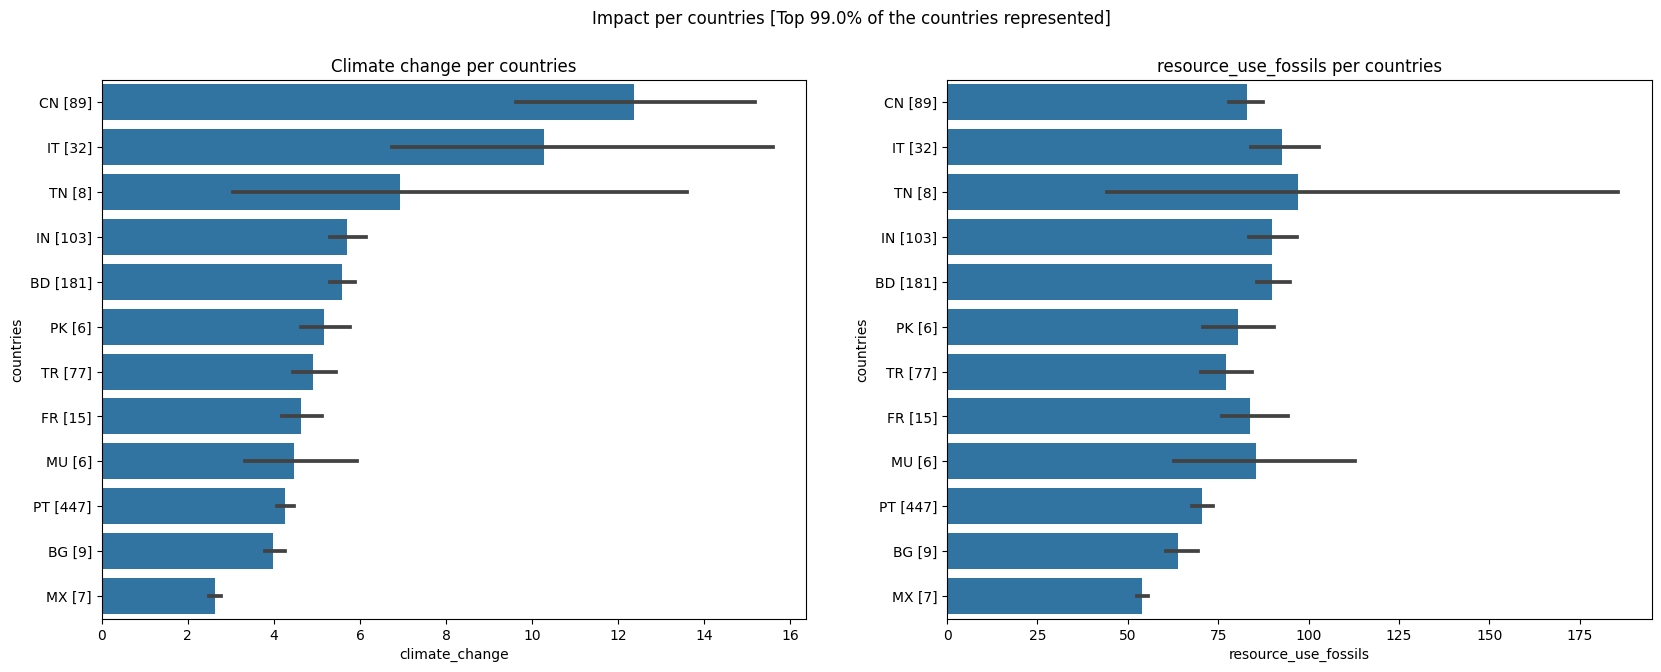

In [20]:
for col in ['raw_material_country', 'weaving_country', 'dyeing_country', 'manufacturing_country']: 
    df = df_raw[df_raw['product_type'] == 'TSHIRTS']
    df['countries'] = df[col].astype(str)
    display_impact_per_category(df, col='countries', split=' ', n=12, add_count=True)

### Distribution of resource_use_fossils vs climate_change

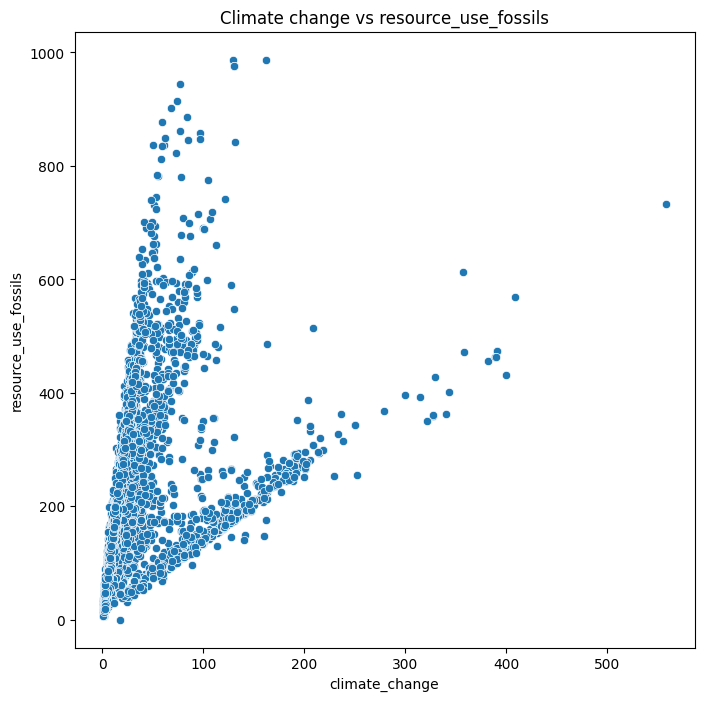

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(df_raw, x='climate_change', y='resource_use_fossils', color='tab:blue', ax=ax)
ax.set_title(f'Climate change vs resource_use_fossils')
plt.show()

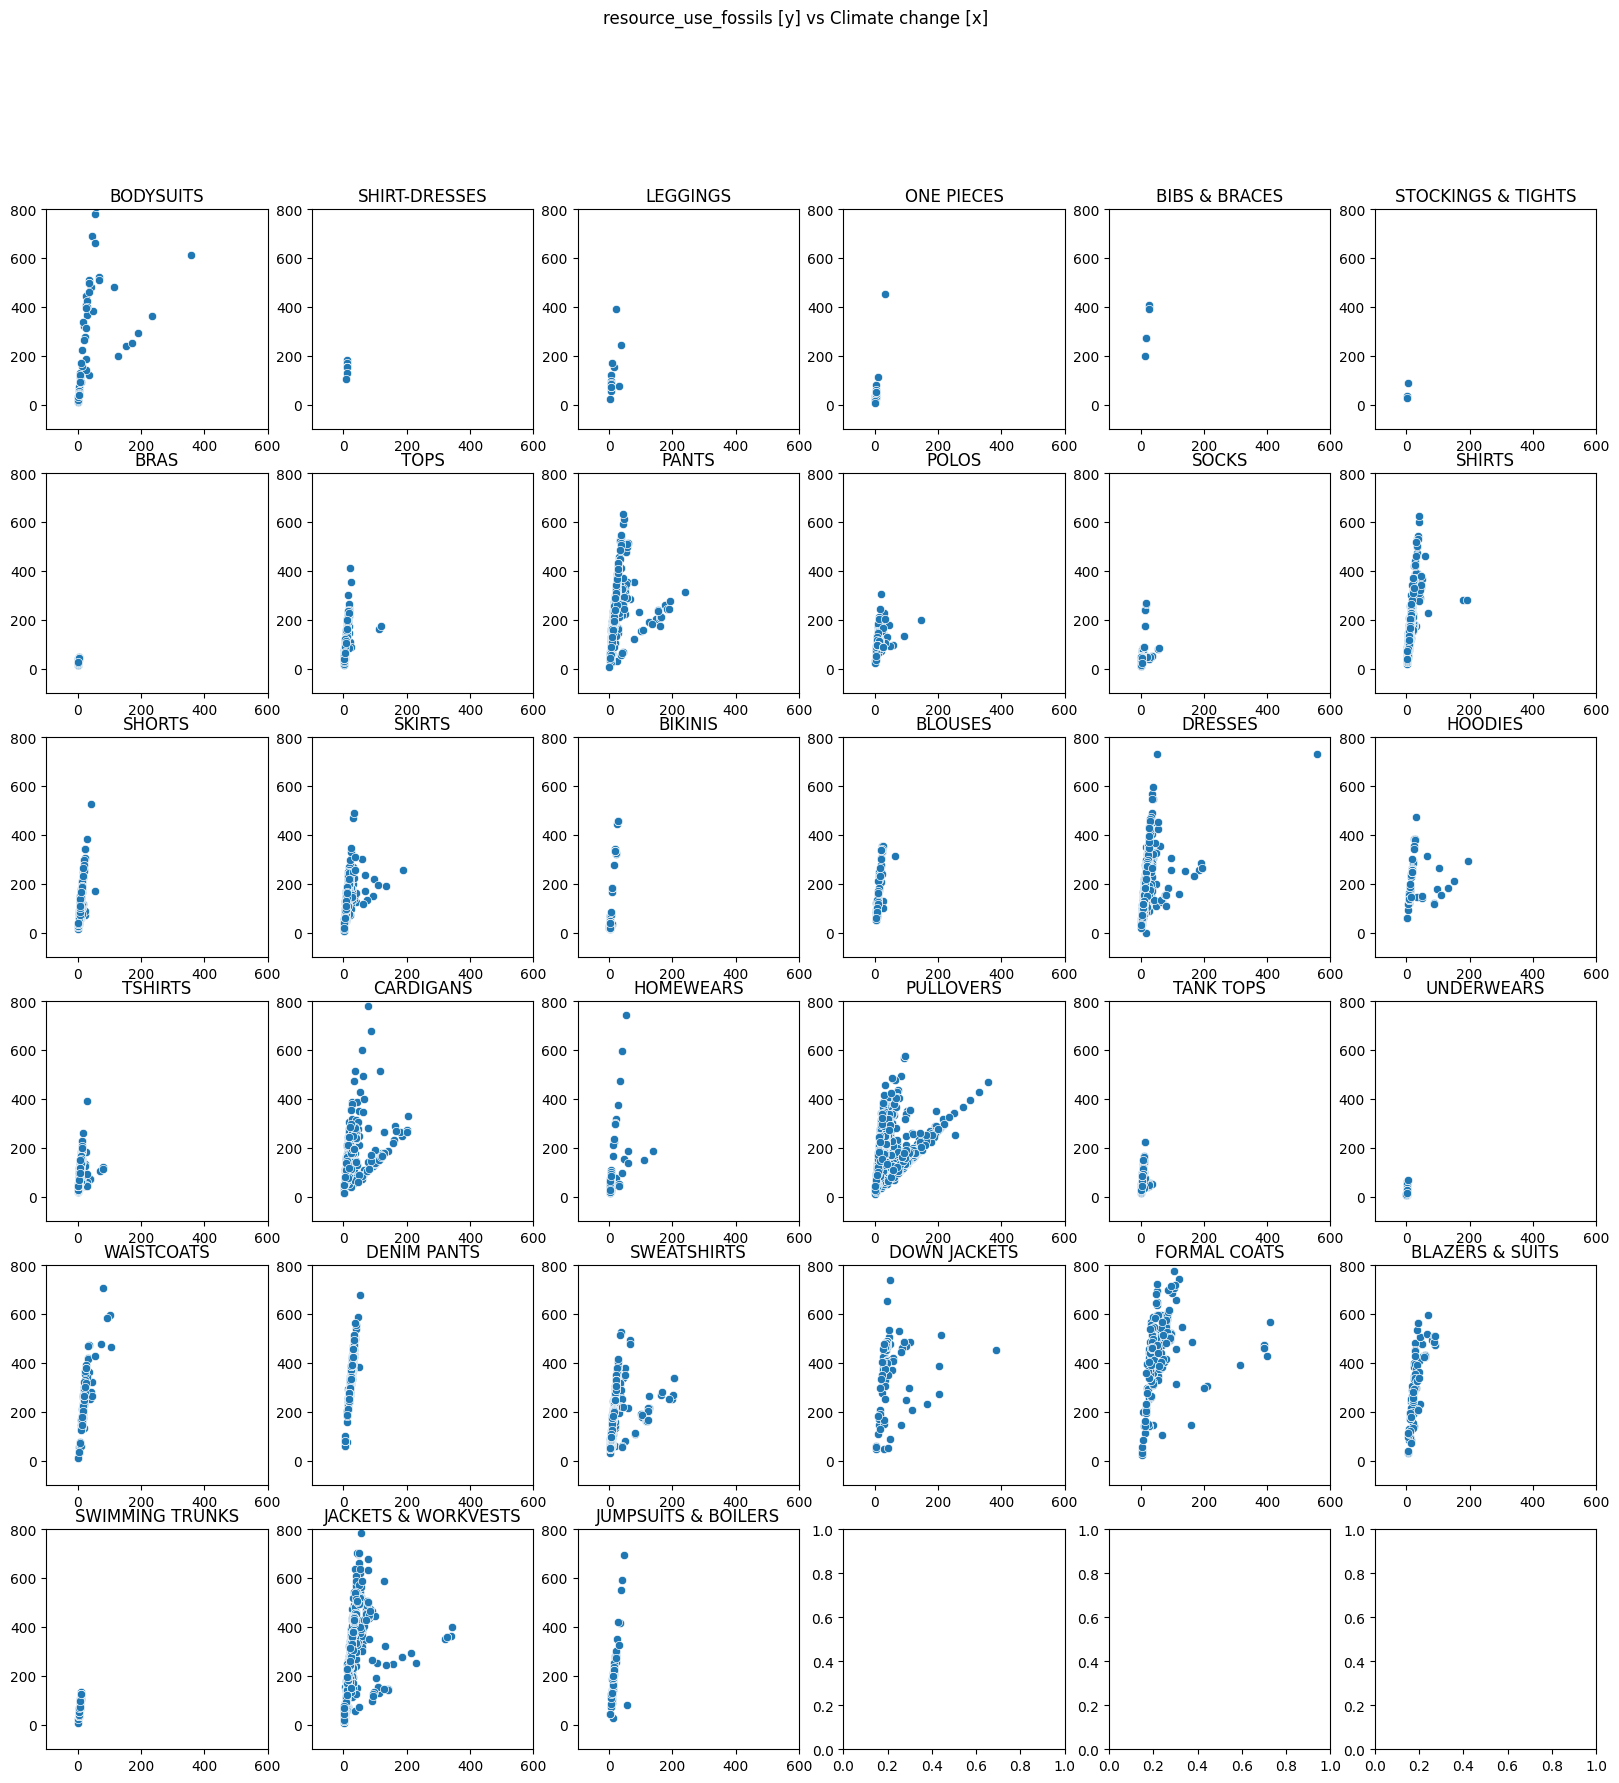

In [20]:
fig, ax = plt.subplots(6, 6, figsize=(20, 20))
r = 0
c = 0

for i, col in enumerate(df_raw['product_type'].unique()):
    df = df_raw[df_raw['product_type'] == col]
    sns.scatterplot(df, x='climate_change', y='resource_use_fossils', color='tab:blue', ax=ax[r,c])
    ax[r,c].set_title(col)

    ax[r,c].set_xlim([-100, 600])
    ax[r,c].set_ylim([-100, 800])
    
    ax[r,c].set(xlabel=None, ylabel=None)
    
    r = int(i/6)
    c = i%6
fig.suptitle('resource_use_fossils [y] vs Climate change [x]')
plt.show()